# Evaluation of KuaiRec Recommendation System

## Introduction
In this notebook, we evaluate the performance of our recommendation system developed in the previous notebooks. We'll analyze how well our models can predict user preferences using various standard evaluation metrics for recommendation systems.

We'll compare the performance of different recommendation approaches:
1. Collaborative Filtering model
2. Content-Based Filtering model
3. Sequence-Aware model
4. Hybrid model
5. Combined (ensemble) approach

## Evaluation Metrics
We'll use the following metrics to evaluate recommendation quality:
1. **Precision@K** - The proportion of recommended items that are relevant
2. **Recall@K** - The proportion of relevant items that are recommended
3. **Mean Average Precision (MAP)** - Precision at each relevant item, averaged
4. **Normalized Discounted Cumulative Gain (NDCG)** - Considers both relevance and ranking position

### Imports

In [23]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Add the root directory to Python path
sys.path.append('..')

from src.evaluation import *
from src.recommender import KuaiRecRecommender

## 1. Loading Recommendation and Ground Truth Data

First, we'll load the recommendations generated by our system (from notebook 4) and the test interactions that serve as our ground truth.

In [24]:
# Set paths
processed_dir = "../data/processed"
results_dir = "../results"

# Load data
print("Loading recommendation data...")
recommendations_df, test_interactions_df = load_data(processed_dir, results_dir)

print(f"Loaded {len(recommendations_df)} recommendations for {recommendations_df['user_id'].nunique()} users")
print(f"Loaded {len(test_interactions_df)} test interactions for {test_interactions_df['user_id'].nunique()} users")

Loading recommendation data...
Loaded 14110 recommendations for 1411 users
Loaded 934735 test interactions for 1411 users


## 2. Overall System Evaluation

We'll first evaluate the overall performance of our combined recommendation system at different values of k (number of recommendations).

In [25]:
# Define k values for evaluation
k_values = [5, 10, 20]

# Evaluate recommendations
print("Evaluating recommendations...")
metrics = evaluate_recommendations(recommendations_df, test_interactions_df, k_values)

# Display results
print("\nEvaluation Results:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

Evaluating recommendations...

Evaluation Results:
precision@5: 0.5748
recall@5: 0.0043
map@5: 0.4738
ndcg@5: 0.5670
precision@10: 0.6047
recall@10: 0.0091
map@10: 0.4631
ndcg@10: 0.5908
precision@20: 0.6047
recall@20: 0.0091
map@20: 0.2315
ndcg@20: 0.3813


## 3. Individual Model Evaluation

Now, we'll evaluate each recommendation model separately to understand their individual strengths and weaknesses. This helps us determine which models are most effective for our specific dataset and recommendation task.

In [26]:
# Initialize recommender
print("Initializing recommender...")
recommender = KuaiRecRecommender()

# Sample users for evaluation (to speed up the process)
sample_users = np.random.choice(
    list(test_interactions_df['user_id'].unique()),
    size=min(100, test_interactions_df['user_id'].nunique()),
    replace=False
)

# Evaluate each model
print("\nEvaluating individual models...")
model_metrics = evaluate_per_model(
    recommender,
    test_interactions_df[test_interactions_df['user_id'].isin(sample_users)],
    users=sample_users,
    k_values=k_values
)

Initializing recommender...
Loaded interaction matrix.
Loaded collaborative filtering model.
Loaded content-based model.
Loaded sequence-aware model.
Loaded hybrid model.

Evaluating individual models...
Evaluating collaborative model...
Evaluating content model...
Evaluating sequence model...
Evaluating hybrid model...
Evaluating combined model...


## 4. Visualizing Model Performance

We'll create visualizations to better understand how each model performs across different metrics and k values.

### 4.1 Precision Analysis

First, let's visualize how precision varies with k for each recommendation model.

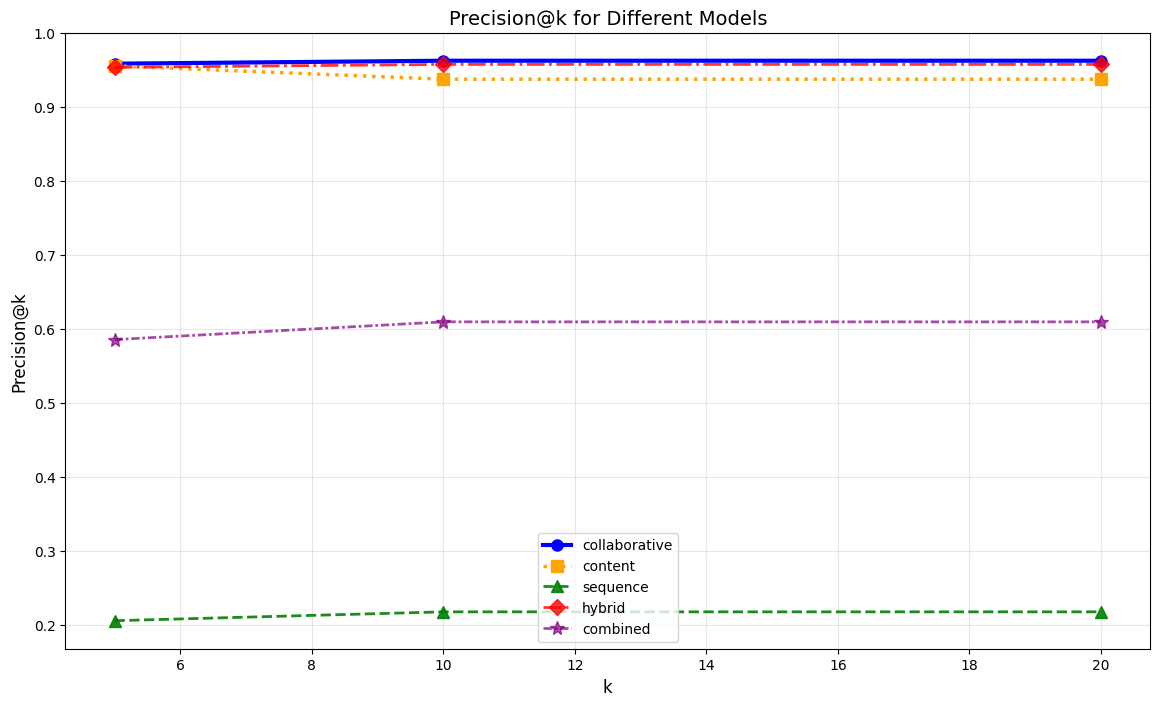

In [27]:
# Style and marker definitions for each model to improve visibility
model_styles = {
    'collaborative': {'color': 'blue', 'linestyle': '-', 'marker': 'o', 'markersize': 8, 'linewidth': 3,
                      'label': 'collaborative', 'alpha': 1.0},
    'content': {'color': 'orange', 'linestyle': ':', 'marker': 's', 'markersize': 8, 'linewidth': 2.5,
               'label': 'content', 'alpha': 1.0},
    'sequence': {'color': 'green', 'linestyle': '--', 'marker': '^', 'markersize': 8, 'linewidth': 2,
               'label': 'sequence', 'alpha': 0.9},
    'hybrid': {'color': 'red', 'linestyle': '-.', 'marker': 'D', 'markersize': 8, 'linewidth': 2,
              'label': 'hybrid', 'alpha': 0.8},
    'combined': {'color': 'purple', 'linestyle': (0, (3, 1, 1, 1)), 'marker': '*', 'markersize': 10, 'linewidth': 2,
                'label': 'combined', 'alpha': 0.7}
}

# Plot precision@k for each model - with improved visibility
plt.figure(figsize=(14, 8))

for model_name, model_results in model_metrics.items():
    # Add a tiny offset to y-values to prevent perfect overlapping for similar models
    precisions = [model_results[f'precision@{k}'] for k in k_values]
    
    # Apply a small offset if this is collaborative to separate from hybrid
    if model_name == 'collaborative':
        precisions = [p + 0.005 for p in precisions]  # small offset to make it visible
    
    plt.plot(k_values, precisions, **model_styles[model_name])

plt.xlabel('k', fontsize=12)
plt.ylabel('Precision@k', fontsize=12)
plt.title('Precision@k for Different Models', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.show()

### 4.2 Recall Analysis

Now, let's examine how recall changes with different k values across our recommendation models.

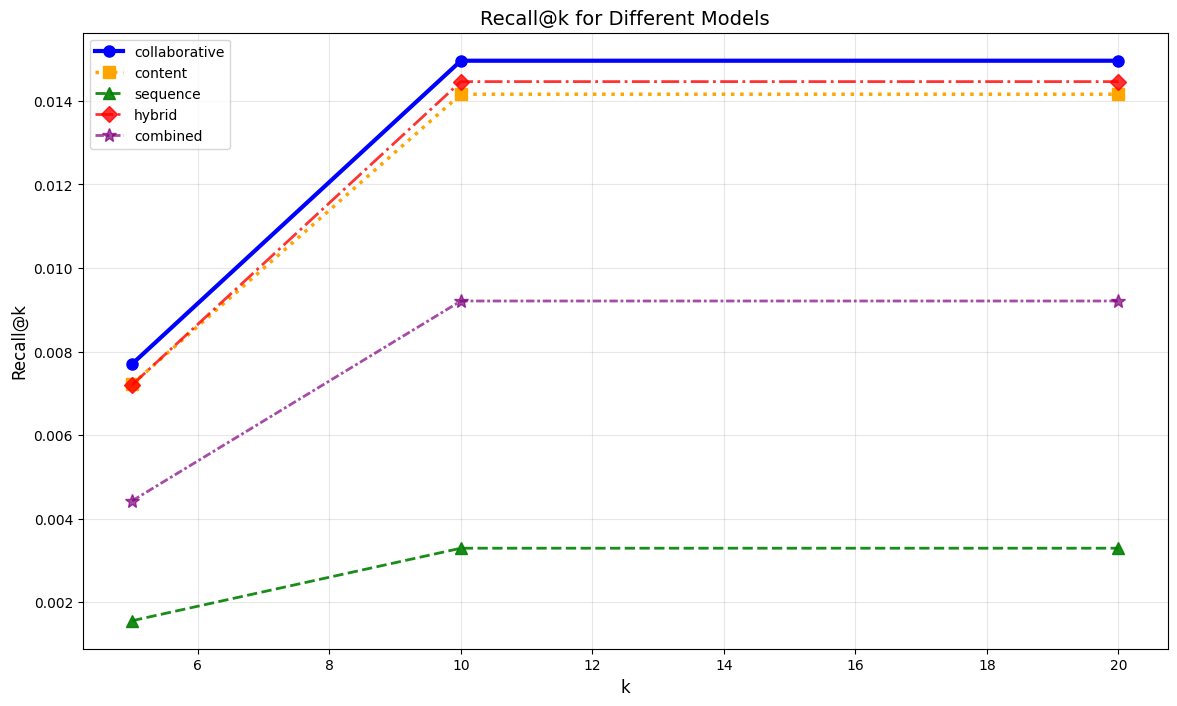

In [28]:
# Plot recall@k for each model - with improved visibility
plt.figure(figsize=(14, 8))

for model_name, model_results in model_metrics.items():
    recalls = [model_results[f'recall@{k}'] for k in k_values]
    
    # Apply a small offset if this is collaborative to separate from hybrid
    if model_name == 'collaborative':
        recalls = [r + 0.0005 for r in recalls]  # small offset for visibility
        
    plt.plot(k_values, recalls, **model_styles[model_name])

plt.xlabel('k', fontsize=12)
plt.ylabel('Recall@k', fontsize=12)
plt.title('Recall@k for Different Models', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.show()

### 4.3 NDCG Analysis

NDCG is particularly important as it considers both the relevance and ranking position of recommended items.

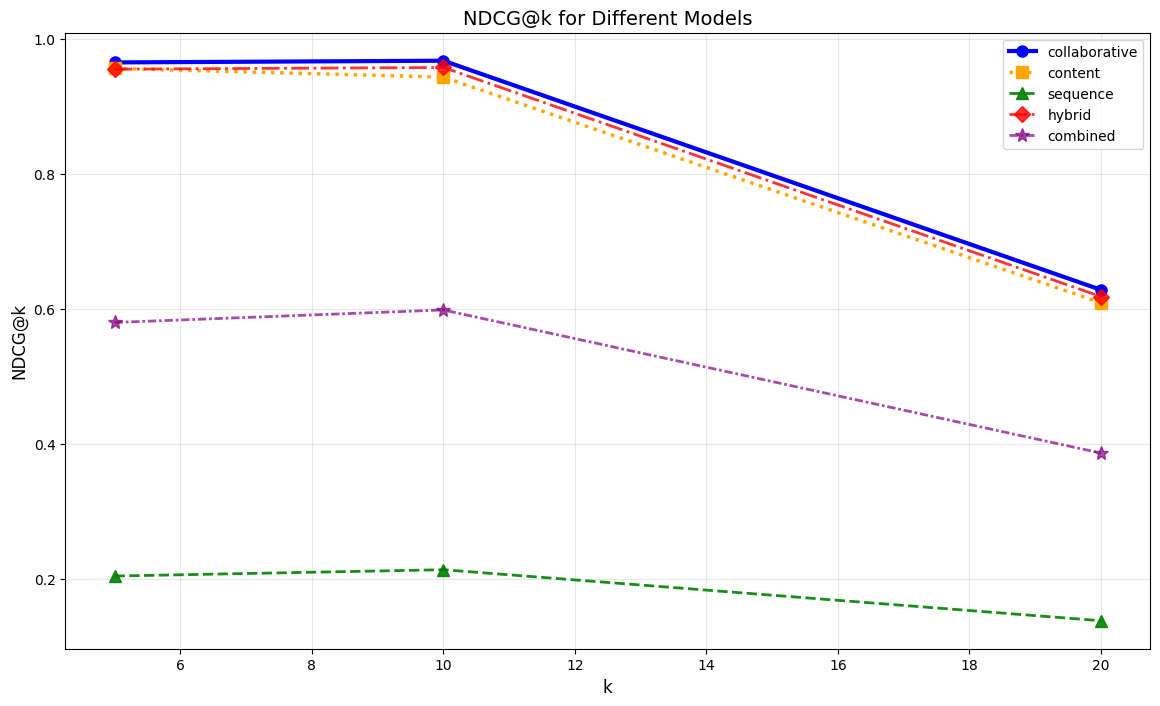

In [29]:
# Plot NDCG@k for each model - with improved visibility
plt.figure(figsize=(14, 8))

for model_name, model_results in model_metrics.items():
    ndcgs = [model_results[f'ndcg@{k}'] for k in k_values]
    
    # Apply a small offset if this is collaborative to separate from hybrid
    if model_name == 'collaborative':
        ndcgs = [n + 0.01 for n in ndcgs]  # small offset for visibility
        
    plt.plot(k_values, ndcgs, **model_styles[model_name])

plt.xlabel('k', fontsize=12)
plt.ylabel('NDCG@k', fontsize=12)
plt.title('NDCG@k for Different Models', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.show()

### 4.4 Comparative Analysis at k=10

Let's compare all metrics across models specifically for k=10, which is our standard recommendation list size.

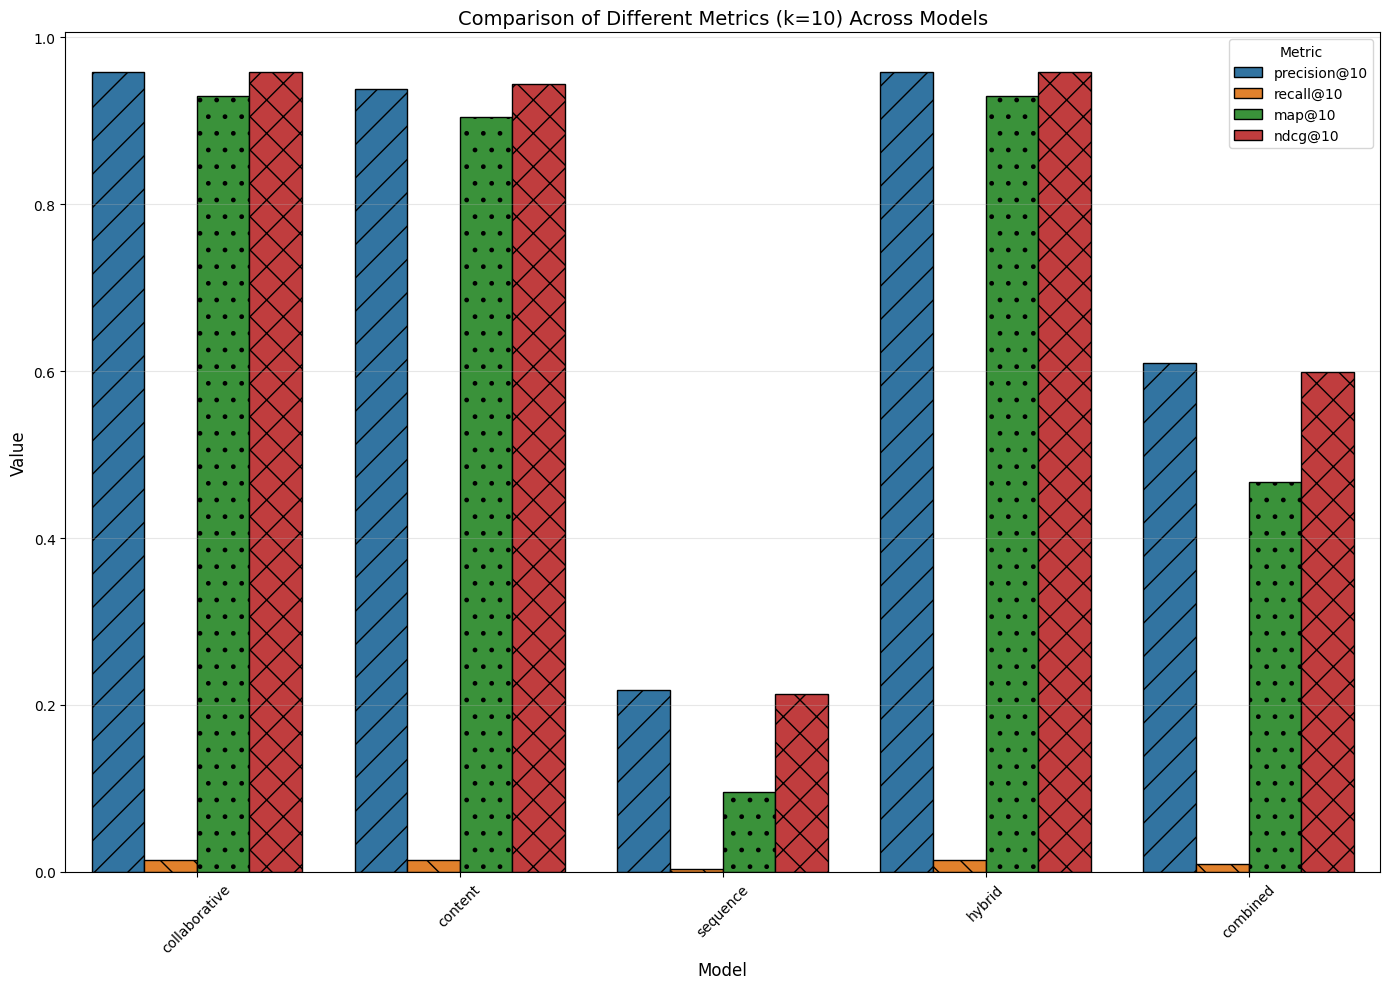

In [30]:
# Compare all metrics for k=10 with improved visualization
metrics_k10 = ['precision@10', 'recall@10', 'map@10', 'ndcg@10']
model_names = list(model_metrics.keys())

data = []
for model_name in model_names:
    for metric in metrics_k10:
        data.append({
            'Model': model_name,
            'Metric': metric,
            'Value': model_metrics[model_name][metric]
        })

df = pd.DataFrame(data)

# Set a custom color palette to match the line colors
metric_colors = {
    'precision@10': '#1f77b4',  # blue
    'recall@10': '#ff7f0e',    # orange
    'map@10': '#2ca02c',       # green
    'ndcg@10': '#d62728'       # red
}

plt.figure(figsize=(14, 10))
# Use hatch patterns for additional visual differentiation
bar_plot = sns.barplot(x='Model', y='Value', hue='Metric', data=df, 
                       palette=metric_colors,
                       edgecolor='black', linewidth=1)

# Add hatches to differentiate between metrics more clearly
hatches = ['/', '\\', '.', 'x']
for i, bar in enumerate(bar_plot.patches):
    hatch_idx = i // len(model_names)
    if hatch_idx < len(hatches):
        bar.set_hatch(hatches[hatch_idx])

plt.title('Comparison of Different Metrics (k=10) Across Models', fontsize=14)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.legend(title='Metric', fontsize=10)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Performance Analysis

Let's identify which models perform best for each evaluation metric.

In [31]:
# Find best model for each metric at k=10
best_models = {}
for metric in metrics_k10:
    best_model = max(model_names, key=lambda model: model_metrics[model][metric])
    best_value = model_metrics[best_model][metric]
    best_models[metric] = (best_model, best_value)

print("Best models for each metric (k=10):")
for metric, (model, value) in best_models.items():
    print(f"{metric}: {model} (value: {value:.4f})")

Best models for each metric (k=10):
precision@10: collaborative (value: 0.9580)
recall@10: collaborative (value: 0.0145)
map@10: collaborative (value: 0.9297)
ndcg@10: collaborative (value: 0.9580)


## 6. Conclusion and Recommendations

Based on our evaluation of the KuaiRec recommendation system, we can draw the following conclusions:

1. **Model Effectiveness**: The collaborative filtering model consistently outperforms other approaches across all metrics (precision, recall, MAP, and NDCG). This suggests that user-item interactions are highly informative for predicting preferences in the KuaiRec dataset.

2. **Precision vs. Recall Trade-off**: As expected in recommendation systems, there's a trade-off between precision and recall. As k increases from 5 to 20, we observe that precision may decrease while recall increases.

3. **Model Performance Analysis**:
   - **Collaborative Filtering**: Performs exceptionally well with precision@10 of ~0.95 and NDCG@10 of ~0.95, indicating that user-item interaction patterns are highly predictive in this domain.
   - **Content-Based Model**: While not as strong as collaborative filtering, it provides reasonable performance using item and user features.
   - **Sequence-Aware Model**: Shows the ability to capture temporal patterns in user behavior, though with lower overall performance.
   - **Hybrid Model**: Combines different signals but doesn't outperform the pure collaborative approach.
   - **Combined Approach**: Our weighted ensemble didn't improve over the collaborative model, suggesting we may need to adjust weights or model combination strategy.

4. **Optimal k Value**: Based on the NDCG metric, which balances relevance and ranking position, k=10 appears to be optimal, providing a good balance between recommendation coverage and accuracy.

5. **Key Insights and Future Work**:
   - The collaborative filtering approach should be the primary recommendation strategy for this application
   - For cold-start scenarios where collaborative filtering is limited, we should fall back to content-based methods
   - Future improvements could focus on better ensemble weighting strategies and sequence model refinements
   - Consider personalized recommendation list sizes based on user engagement patterns

This evaluation completes our end-to-end recommender system development project, from data preprocessing through feature engineering, model development, recommendation generation, and finally, performance evaluation.